# Projekt 3 - DBSCAN 

Autor: Kateřina Kolaříková, kol0436

Cílem tohoto projektu je naimplementovst algoritmus DBSCSN a porovnat jej s verzí, která je spolu s dalšími algoritmy dostupná v knihovně scikit-learn.

## Princip algoritmu

Tento algoritmus je založen na principu shlukování bodů v prostoru. Jeho princip je následující:

Nejdříve dojde k rozdělení bodů na základě jejich polohy a množsví bodů v jejich okolí. Jedná se o tzv. Core points ( mám minimálně min_pts bodů v okolí epsilon), Border points (nemá ve svém okolí min_pts bodů, nachází se však v okolí některého z Core bodů) a Noise points (není ani jedno z předešlého).

Následně dojde k přiřazení bodů do shluků:
1. Vybere se náhodný core point, který ještě nebyl přiřazen do žádného shluku.
2. Vyhledají se všechny body, které jsou v jeho okolí (vzdálenost je definována parametrem epsilon).
3. Tyto body se přiřadí do shluku.
4. Pro všechny core point, které byly přiřazeny do shluku, se opakuje krok 2.

Princip fungování tohoto algoritmu a z něj vyplývající detaily implementace byl převzat z https://scikit-learn.org/stable/modules/clustering.html#dbscan.



## Implementace

### Třída Point

Nejdříve je nutné vytvořit třídu Point, která bude reprezentovat jednotlivé body v prostoru. Tato třída bude obsahovat následující atributy:
- x - souřadnice x
- y - souřadnice y
- cluster_type - typ bodu (core, border, noise)
- cluster - číslo shluku, do kterého byl bod přiřazen
- neighbors - pole sousedních bodů

In [86]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cluster_type = None
        self.cluster = None
        self.neighbors = None


### Třída DBSCAN

Tato třída obsahuje všechny metody potřebné pro samotný algoritmus DBSCAN. 

Atributy této třídy jsou:
- eps - vzdálenost, která určuje okolí bodu
- min_pts - minimální počet bodů v okolí
- points - pole všech bodů

Metody této třídy jsou:
- euclideanDistance, manhattanDistance - vypočítá vzdálenost mezi dvěma body
- dbscan - samotný algoritmus DBSCAN, projde jednotlivé body a zavolá metody které určí typ bodu a přiřadí body do shluků
- get_neighbors - vrátí všechny body v okolí zadaného bodu
- mark_neighbours - přiřadí body do shluků a zavolá se rekurzivně pro všechny core points v okolí
- print_plot - zobrazí výsledek shlukování
- run - načte body ze souboru a spustí algoritmus DBSCAN

In [70]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [71]:
class DBSCAN:
    def __init__(self):
        self.eps = None
        self.min_pts = None
        self.points = []
        
    def euclideanDistance(self, point1, point2):
         return math.sqrt((point2.x - point1.x) ** 2 + (point2.y - point1.y) ** 2)

    def manhattanDistance(self, point1, point2):
        return abs(point2.x - point1.x) + abs(point2.y - point1.y)

    
    def dbscan(self ):
        for p in self.points:
            # go through unvisited points
            if p.cluster is not None:
                continue  # Already assigned to a cluster
            # get a neighbours of unvisited point
            p.neighbors = self.get_neighbors(p)
            # test if each point has the minimum neighbours, if so, its considered as a core point
            if len(p.neighbors) < self.min_pts:
                p.cluster_type = "n"  # Mark as noise
                p.cluster = -1 
            else:
                p.cluster_type = "c"  # Mark as core point
                
        # specify clusters for each core point and its associated points
        cluster_id = 0
        for p in self.points:
            # go through unvisited core points
            if p.cluster is None and p.cluster_type == "c":
                # find all points touching core point and assign them to the same cluster
                self.mark_neighbours(p, cluster_id)
                cluster_id += 1
    
    def get_neighbors(self,point):
        # return all points within P's eps-neighborhood (including P)
        return [p for p in self.points if self.euclideanDistance(point, p) < self.eps]
    
    def mark_neighbours(self,point, cluster_id):
        # get the neighbours which are not visited yet
        unvisited_neighbors = [p for p in point.neighbors if p.cluster is None]
        if len(unvisited_neighbors) > 0:
            for p in unvisited_neighbors:
                p.cluster = cluster_id # assign point to cluster
                # if the neighbour is core point, check its neighbours recursively
                if p.cluster_type == "c":
                    self.mark_neighbours(p, cluster_id)
                else:
                    return
        else:
             return
    
    
    def print_plot(self):
        # get unique clusters
        unique_clusters = set([point.cluster for point in self.points])
        cluster_colors = {}
    
        # generate required number of colors
        for cluster in unique_clusters:
            cluster_colors[cluster] = np.random.rand(3, )  # generate field with given size and values between 0 and 1
    
        # plot points with specific colors for each cluster    
        for point in self.points:
            plt.scatter(point.x, point.y, color=cluster_colors[point.cluster])

        plt.show()
        
    def run (self, epsilon, min_pts, file_name):
        self.eps = epsilon
        self.min_pts = min_pts
        with open(file_name, 'r') as file:
            csvreader = csv.reader(file)
            for row in csvreader:
                coordinates = row[0].split(';')
                tmp_p = Point(float(coordinates[0]), float(coordinates[1]))
                self.points.append(tmp_p)

        start_time = time.time()
        self.dbscan()
        end_time = time.time()
        print("Time: ", end_time - start_time)

### Výsledek

Následně je možné spustit algoritmus shlukování. Jako výsledek je zobrazen nejen graf s výsledným shlukováním, ale také čas, který algoritmus potřeboval pro svůj běh. Každý shluk, stejně jako body, které byly vyhonoceny jako noise, je zobrazen jinou barvou.

Time:  0.0581972599029541


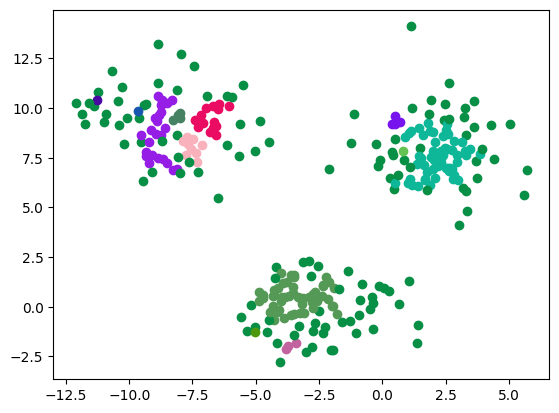

In [72]:
dbscan = DBSCAN()
dbscan.run(0.5, 4, "clusters5n.csv")
dbscan.print_plot()

## Porovnání algoritmu s algoritmem z knihovny scikit-learn

Následně je možné porovnat výsledky algoritmu s verzí, která je dostupná v knihovně scikit-learn.

V případě prvního datasetu je zároveň vykreslený grafický výsledek pro oba algoritmy. V dalších případech je pouze vypsán čas, který algoritmus potřeboval pro svůj běh. Pro každé shlukování je také vypsáno, kolik bodů obsahuje (počet bodů odpovídá počtu řádků v souboru).

Je zřejmé, že úměrně s délkou souboru roste také doba zpracování. V případě mnou naimplemenotovaného algoritmu je doba zpracování až 2.27, kdežto v případě algoritmu, který je součástí knihovny doba nikdy nepřekročí dobu jedné sekundy. V případě prvního datasetu je cca 36x rychlejší, v druhém 400x, ve třetím 366x a v posledním dokonce 490x.

Velká náročnost může být dána například velkým množstvím for cyklů. kdy se opakovaně prochází ty stejné body, především v metodě dbscan. Zároveň jsou cykly "skryty" také v rámci list comprehension. Jednou z možných úprav by proto být například dělit body do clusterů v momentě. kdy se jedná o core point.

In [73]:
from sklearn.cluster import DBSCAN

In [74]:
filename = "clusters3.csv"
with open(filename, 'r') as fp:
    x = len(fp.readlines())
    print('Total lines:', x) 

Total lines: 300


Time:  0.05614471435546875


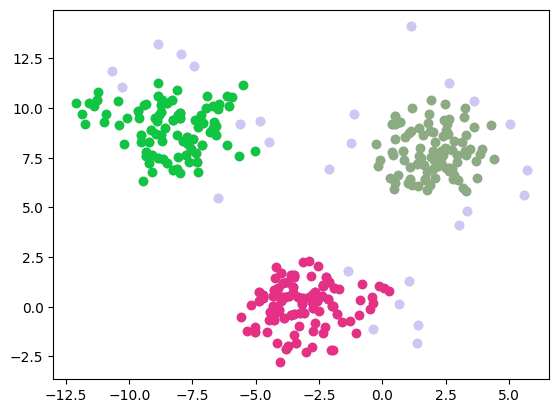

In [75]:
dbscan.run(0.9, 5, filename)
dbscan.print_plot()

Time:  0.0015497207641601562


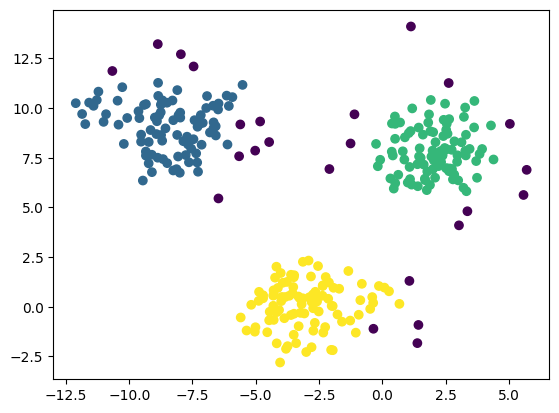

In [76]:
X = np.loadtxt(filename, delimiter=';')
start_time = time.time()
clustering = DBSCAN(eps=0.9, min_samples=5).fit(X)
end_time = time.time()
print("Time: ", end_time - start_time)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

In [77]:
filename = "boxes.csv"
with open(filename, 'r') as fp:
    x = len(fp.readlines())
    print('Total lines:', x) 

Total lines: 2500


In [78]:
dbscan.run(0.9, 5, filename)

Time:  2.2743051052093506


In [79]:
X = np.loadtxt(filename, delimiter=';')
start_time = time.time()
clustering = DBSCAN(eps=0.9, min_samples=5).fit(X)
end_time = time.time()
print("Time: ", end_time - start_time)

Time:  0.005684375762939453


In [80]:
filename = "clusters5n.csv"
with open(filename, 'r') as fp:
    x = len(fp.readlines())
    print('Total lines:', x)

Total lines: 1000


In [81]:
dbscan.run(0.9, 5, filename)

Time:  1.17635178565979


In [82]:
X = np.loadtxt(filename, delimiter=';')
start_time = time.time()
clustering = DBSCAN(eps=0.9, min_samples=5).fit(X)
end_time = time.time()
print("Time: ", end_time - start_time)

Time:  0.0032105445861816406


In [83]:
filename = "annulus.csv"
with open(filename, 'r') as fp:
    x = len(fp.readlines())
    print('Total lines:', x)

Total lines: 1000


In [84]:
dbscan.run(0.9, 5, filename)

Time:  1.4642157554626465


In [85]:
X = np.loadtxt(filename, delimiter=';')
start_time = time.time()
clustering = DBSCAN(eps=0.9, min_samples=5).fit(X)
end_time = time.time()
print("Time: ", end_time - start_time)

Time:  0.002985239028930664


## Závěr

V rámci tohoto projektu došlo k úspěšnému naimplementování algoritmu DBSCAN se dvěmi parametry a to eps a min_pts. Pro to byly vytvořeny dvě třídy, kdy jedna reprezentuje bod, který se snažíme shlukovat a druhá obsahuje všechny atributy a metody nutné pro samotný průběh algoritmu. Tato implementace proběhla úspěšně a je blíže popsána v příslušných sekcích. Následně bylo také provedeno několik shlukování s různými datasety.

V poslední části pak byl porovnán algoritmus pro DBSCAN který je součástí knihovny scikit learn s mou implementací. V tomto porovnání si algoritmus, který je součástí knihovny vedl výrazně lépe než algoritmus naimplementovaný v rámci projektu a bylo proto na místě se také zamyslet, zda by se dal algoritmus naimplementovat také efektivnějším způsobem.